# Time series of revert risk

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import re
import csv
from tqdm import tqdm
from collections import Counter
import matplotlib.dates as mdates
import datetime
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
tqdm.pandas()

# Set width
pd.set_option('display.max_colwidth', 50)

# Set random seed
np.random.seed(42)  # or any consistent seed value

# Configuration
LOWESS_FRAC = 0.1  # LOWESS smoothing fraction

## Set-up & Pre-processing

In [ ]:
# Load df
df_raw = pd.read_csv('data/df_wikimedia_full_dataset.csv')
df_raw.head(3)

,revid,prediction,prob_true,prob_false,user,timestamp,comment,page_title,parentid,affiliation,pol_type,category
0,1131745377,False,0.290185,0.709815,Upton Liptrot,2023-01-05 15:17:36+00:00,/* External links */,Ed Case,1.130748e+09,Democrat,house,House
1,1215738747,False,0.234020,0.765980,Upton Liptrot,2024-03-26 20:57:24+00:00,/* External links */,Ed Case,1.214732e+09,Democrat,house,House
2,993040664,False,0.096793,0.903207,Pvmoutside,2020-12-08 13:55:13+00:00,/* External links */,Ed Case,9.891951e+08,Democrat,house,House


In [31]:
# Dataset overview
print(f"Total rows: {len(df_raw)}")
print(f"\nAffiliation breakdown:")
print(df_raw.affiliation.value_counts())

Total rows: 159053

Affiliation breakdown:
affiliation
Republican     84469
Democrat       69678
Independent     3214
Name: count, dtype: int64


In [32]:
# Create party and candidate subsets
df_reps = df_raw[df_raw['affiliation'] == 'Republican'].copy()
df_dems = df_raw[df_raw['affiliation'] == 'Democrat'].copy()
df_inds = df_raw[df_raw['affiliation'] == 'Independent'].copy()
df_trump = df_raw[df_raw['page_title'] == 'Donald Trump'].copy()
df_harris = df_raw[df_raw['page_title'] == 'Kamala Harris'].copy()
df_biden = df_raw[df_raw['page_title'] == 'Joe Biden'].copy()

In [ ]:
# Pre-process df
def process_dataframe(df, true_col, false_col):
    """Convert timestamp to datetime index, aggregate numeric columns by day, subset and rename columns."""
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp')
    numeric_columns = df.select_dtypes(include=['number']).columns
    df = df[numeric_columns].groupby(pd.Grouper(freq='D')).mean().reset_index()
    df = df[['timestamp', 'prob_true', 'prob_false']]
    return df.rename(columns={'prob_true': true_col, 'prob_false': false_col})

In [34]:
# Process all dataframes
df_reps = process_dataframe(df_reps, 'reps_true', 'reps_false')
df_dems = process_dataframe(df_dems, 'dems_true', 'dems_false')
df_inds = process_dataframe(df_inds, 'inds_true', 'inds_false')
df_trump = process_dataframe(df_trump, 'trump_true', 'trump_false')
df_harris = process_dataframe(df_harris, 'harris_true', 'harris_false')
df_biden = process_dataframe(df_biden, 'biden_true', 'biden_false')

In [35]:
# Merge party affiliation dataframes
df_merged1 = pd.merge(df_reps, df_dems, on='timestamp', how='inner')
df_merged2 = pd.merge(df_merged1, df_inds, on='timestamp', how='inner')
print(f"Merged party data: {len(df_merged2)} days")

Merged party data: 1362 days


In [36]:
# Merge candidate dataframes
df_candidates1 = pd.merge(df_trump, df_harris, on='timestamp', how='inner')
df_candidates = pd.merge(df_candidates1, df_biden, on='timestamp', how='inner')
print(f"Merged candidate data: {len(df_candidates)} days")

Merged candidate data: 1362 days


## Descriptive Statistics

In [37]:
# Peak damaging edit risk days by party affiliation
print("=== Top damaging edit risk days by party ===")
print("\nRepublicans:")
print(df_merged2.nlargest(5, 'reps_true')[['timestamp', 'reps_true', 'reps_false']])
print("\nDemocrats:")
print(df_merged2.nlargest(5, 'dems_true')[['timestamp', 'dems_true', 'dems_false']])
print("\nIndependents:")
print(df_merged2.nlargest(5, 'inds_true')[['timestamp', 'inds_true', 'inds_false']])

=== Top damaging edit risk days by party ===

Republicans:
                     timestamp  reps_true  reps_false
342  2021-10-11 00:00:00+00:00   0.809311    0.190689
1304 2024-05-30 00:00:00+00:00   0.804787    0.195213
1348 2024-07-13 00:00:00+00:00   0.803522    0.196478
450  2022-01-27 00:00:00+00:00   0.800223    0.199777
680  2022-09-14 00:00:00+00:00   0.798750    0.201250

Democrats:
                     timestamp  dems_true  dems_false
327  2021-09-26 00:00:00+00:00   0.868392    0.131608
1356 2024-07-21 00:00:00+00:00   0.804949    0.195051
1244 2024-03-31 00:00:00+00:00   0.793960    0.206040
982  2023-07-13 00:00:00+00:00   0.787982    0.212018
297  2021-08-27 00:00:00+00:00   0.787425    0.212575

Independents:
                     timestamp  inds_true  inds_false
1195 2024-02-11 00:00:00+00:00   0.991725    0.008275
1145 2023-12-23 00:00:00+00:00   0.990792    0.009208
1142 2023-12-20 00:00:00+00:00   0.990511    0.009489
1070 2023-10-09 00:00:00+00:00   0.989981    0.010

In [38]:
# Peak damaging edit risk days by candidate
print("=== Top damaging edit risk days by candidate ===")
print("\nTrump:")
print(df_candidates.nlargest(5, 'trump_true')[['timestamp', 'trump_true', 'trump_false']])
print("\nBiden:")
print(df_candidates.nlargest(5, 'biden_true')[['timestamp', 'biden_true', 'biden_false']])
print("\nHarris:")
print(df_candidates.nlargest(5, 'harris_true')[['timestamp', 'harris_true', 'harris_false']])

=== Top damaging edit risk days by candidate ===

Trump:
                    timestamp  trump_true  trump_false
461 2022-02-07 00:00:00+00:00    0.971227     0.028773
264 2021-07-25 00:00:00+00:00    0.968296     0.031704
497 2022-03-15 00:00:00+00:00    0.961997     0.038003
426 2022-01-03 00:00:00+00:00    0.954920     0.045080
774 2022-12-17 00:00:00+00:00    0.954043     0.045957

Biden:
                     timestamp  biden_true  biden_false
497  2022-03-15 00:00:00+00:00    0.969982     0.030018
1017 2023-08-17 00:00:00+00:00    0.958951     0.041049
250  2021-07-11 00:00:00+00:00    0.956867     0.043133
147  2021-03-30 00:00:00+00:00    0.956183     0.043817
110  2021-02-21 00:00:00+00:00    0.948250     0.051750

Harris:
                     timestamp  harris_true  harris_false
91   2021-02-02 00:00:00+00:00     0.963421      0.036579
271  2021-08-01 00:00:00+00:00     0.959763      0.040237
497  2022-03-15 00:00:00+00:00     0.958621      0.041379
1333 2024-06-28 00:00:00+00:

## Data Preparation for Visualization

In [ ]:
# Prepare data for plotting
def process_df(df):
    """Convert timestamp to datetime index, fill missing values, and aggregate numeric columns by day."""
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp')
    df = df.ffill().bfill()
    numeric_columns = df.select_dtypes(include=['number']).columns
    return df[numeric_columns].groupby(pd.Grouper(freq='D')).sum()


df_merged2 = process_df(df_merged2)
df_candidates = process_df(df_candidates)

In [40]:
# Key dates for annotations
events = {
    '2020-11-07': 'Biden wins the 2020 presidential election',
    '2021-01-06': 'Capitol attack & 2nd Trump impeachment',
    '2021-01-20': 'Biden inaugurates as 46th president',
    '2021-02-02': 'Harris speaks with Trudeau in first foreign leader call',
    '2021-02-13': 'Trump acquitted by Senate & Biden announces orders on climate change',
    '2021-03-30': 'Biden signs the American Rescue Plan into law',
    '2021-04-26': '2020 census apportionment figures released',
    '2021-06-26': 'Trump begins campaign-style rallies',
    '2021-07-11': 'Biden delivers a speech about his first 6 months in office',
    '2021-08-01': 'Harris visits Vietnam',
    '2021-08-27': 'Biden addresses Afghanistan evacuation amid Taliban takeover',
    '2021-10-03': 'Trump holds a rally in Iowa & House Select Committee investigates Capitol attack',
    '2022-01-03': 'January 6 committee reports are made public',
    '2022-01-19': 'Biden announces Strategy Against Covid & Harris as running mate in 2024',
    '2022-02-27': 'Trump wins the 2022 CPAC straw poll',
    '2022-03-15': 'Trump holds a rally in SC & Biden signs the Consolidated Appropriations Act',
    '2022-05-02': 'Leaked draft opinion on overturning Roe v. Wade',
    '2022-06-06': 'Supreme Court ruled on voting rights and election laws',
    '2022-06-24': 'Supreme Court overturns Roe v. Wade',
    '2022-09-14': "Senate votes on climate change & Harris speaks on women's rights",
    '2022-11-08': '2022 Midterm elections',
    '2022-11-20': 'Trump announces 2024 presidential candidacy',
    '2023-01-03': 'Kevin McCarthy elected new House Speaker',
    '2023-02-14': 'Haley announces bid for Republican nomination',
    '2023-04-25': 'Biden announces re-election bid',
    '2023-05-24': 'DeSantis, Pence & Burgum to run for president',
    '2023-06-13': 'Trump pleads not guilty to 37 felony counts & West to run for president',
    '2023-07-08': 'Iowa Republican Party sets caucus date for January 15, 2024',
    '2023-08-23': 'First Republican primary debate & Biden visited a community centre in Arizona',
    '2023-10-29': "Trump's rally in Nevada, Mike Johnson new House Speaker",
    '2024-01-15': 'Iowa Republican caucuses & New Hampshire primaries',
    '2024-02-03': 'S. Carolina & Nevada Democratic primary',
    '2024-02-24': 'Nevada, Virgin Islands, S. Carolina & Michigan Rep caucuses/primaries',
    '2024-03-05': 'Super Tuesday primaries',
    '2024-04-25': 'Biden announces re-election bid, Harris confirmed as running mate',
    '2024-05-23': 'Reform Party nominates Kennedy & Trump found guilty in NY trial',
    '2024-06-27': 'First Biden-Trump debate',
    '2024-07-13': "Trump's assassination attempt, RNC & Biden drops out",
}

## Plotting

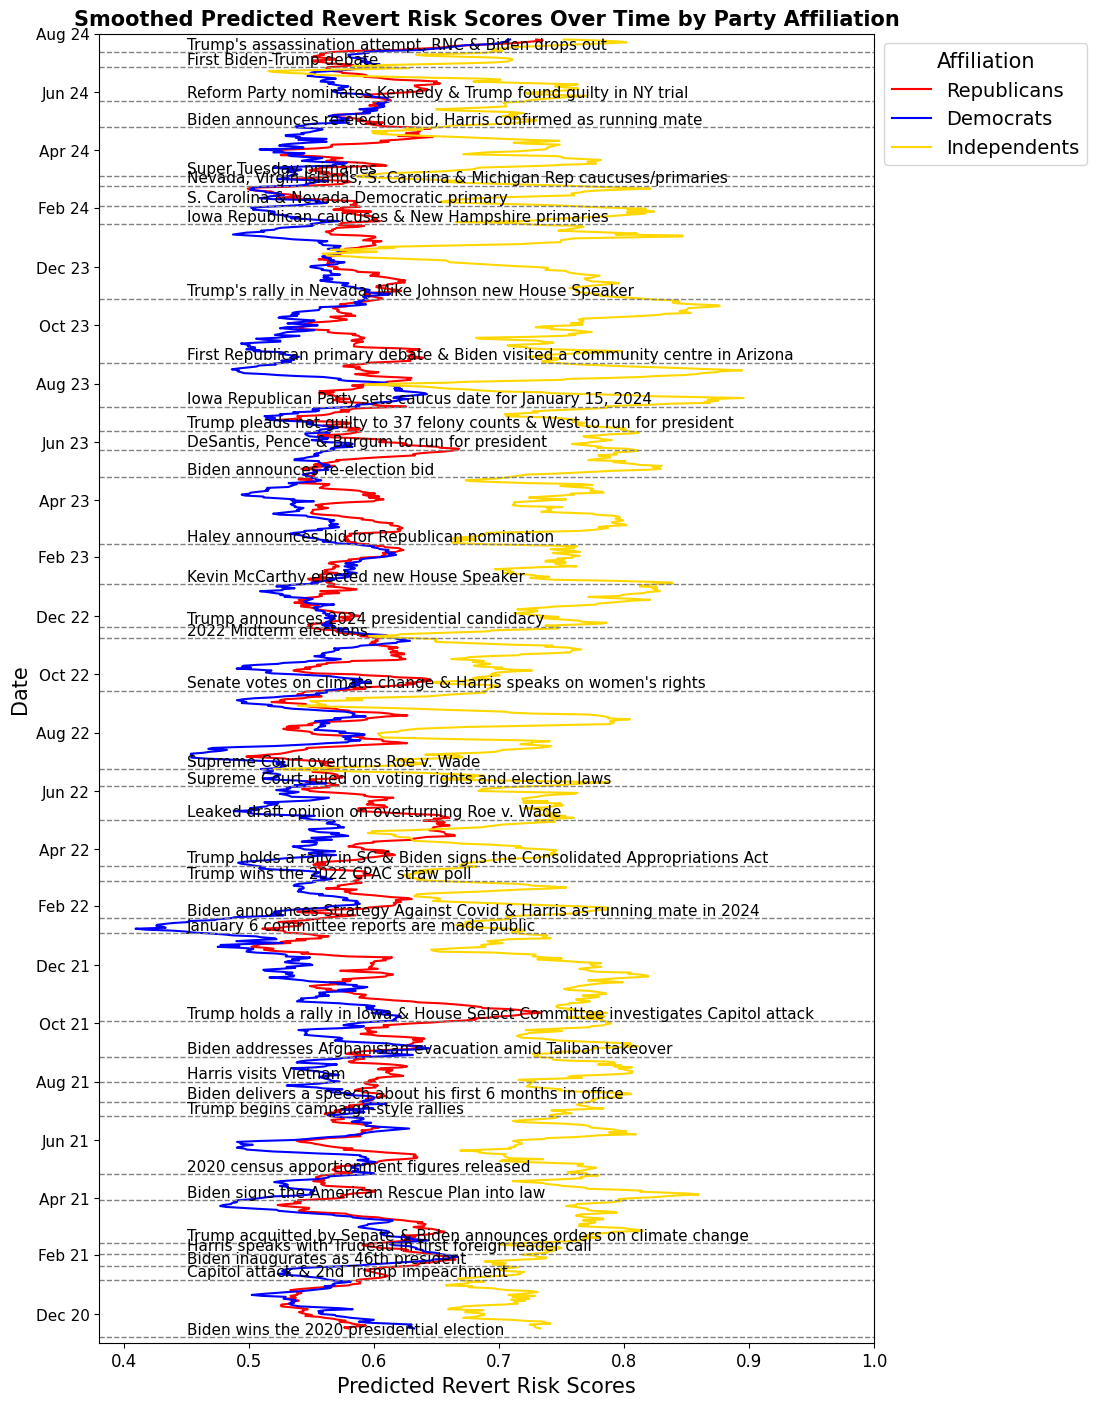

In [41]:
# Define columns
true_columns = ['reps_true', 'dems_true', 'inds_true']

# Define the corresponding colors for each column
colors = {
    'dems_true': 'blue',
    'reps_true': 'red',
    'inds_true': 'gold'
}

# Define the labels for each column
labels = {
    'dems_true': 'Democrats',
    'reps_true': 'Republicans',
    'inds_true': 'Independents',
}

# Plot the smoothed positive sentiment
plt.figure(figsize=(10, 17))

for true_column in true_columns:
    # Smooth the positive sentiment
    smoothed_positive = df_merged2[true_column].rolling(window=14).mean()

    # Plot the smoothed positive sentiment with dates on the y-axis
    plt.plot(smoothed_positive, df_merged2.index, label=labels[true_column], color=colors[true_column])

# Add horizontal lines and annotations for key dates
for date, event in events.items():
    plt.axhline(pd.to_datetime(date), color='gray', linestyle='--', linewidth=1)
    plt.text(0.45, pd.to_datetime(date), event, rotation=0, verticalalignment='bottom', fontsize=11)

# Configure y-axis for monthly ticks
plt.gca().yaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

# Set limits (inverted axes)
plt.xlim(0.38, 1)  # Scores on x-axis
plt.ylim(pd.to_datetime('2020-11'), pd.to_datetime('2024-08'))  

plt.ylabel('Date', fontsize=15)  # Date label on y-axis
plt.xlabel('Predicted Revert Risk Scores', fontsize=15) 
plt.title('Smoothed Predicted Revert Risk Scores Over Time by Party Affiliation', fontsize=15, fontweight='bold')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title='Affiliation', fontsize=14, title_fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=11)

# Save the plot in high resolution
plt.savefig('figures/time-series-risk-party-affiliation.png', dpi=400, bbox_inches='tight')

# Show plot
plt.show()


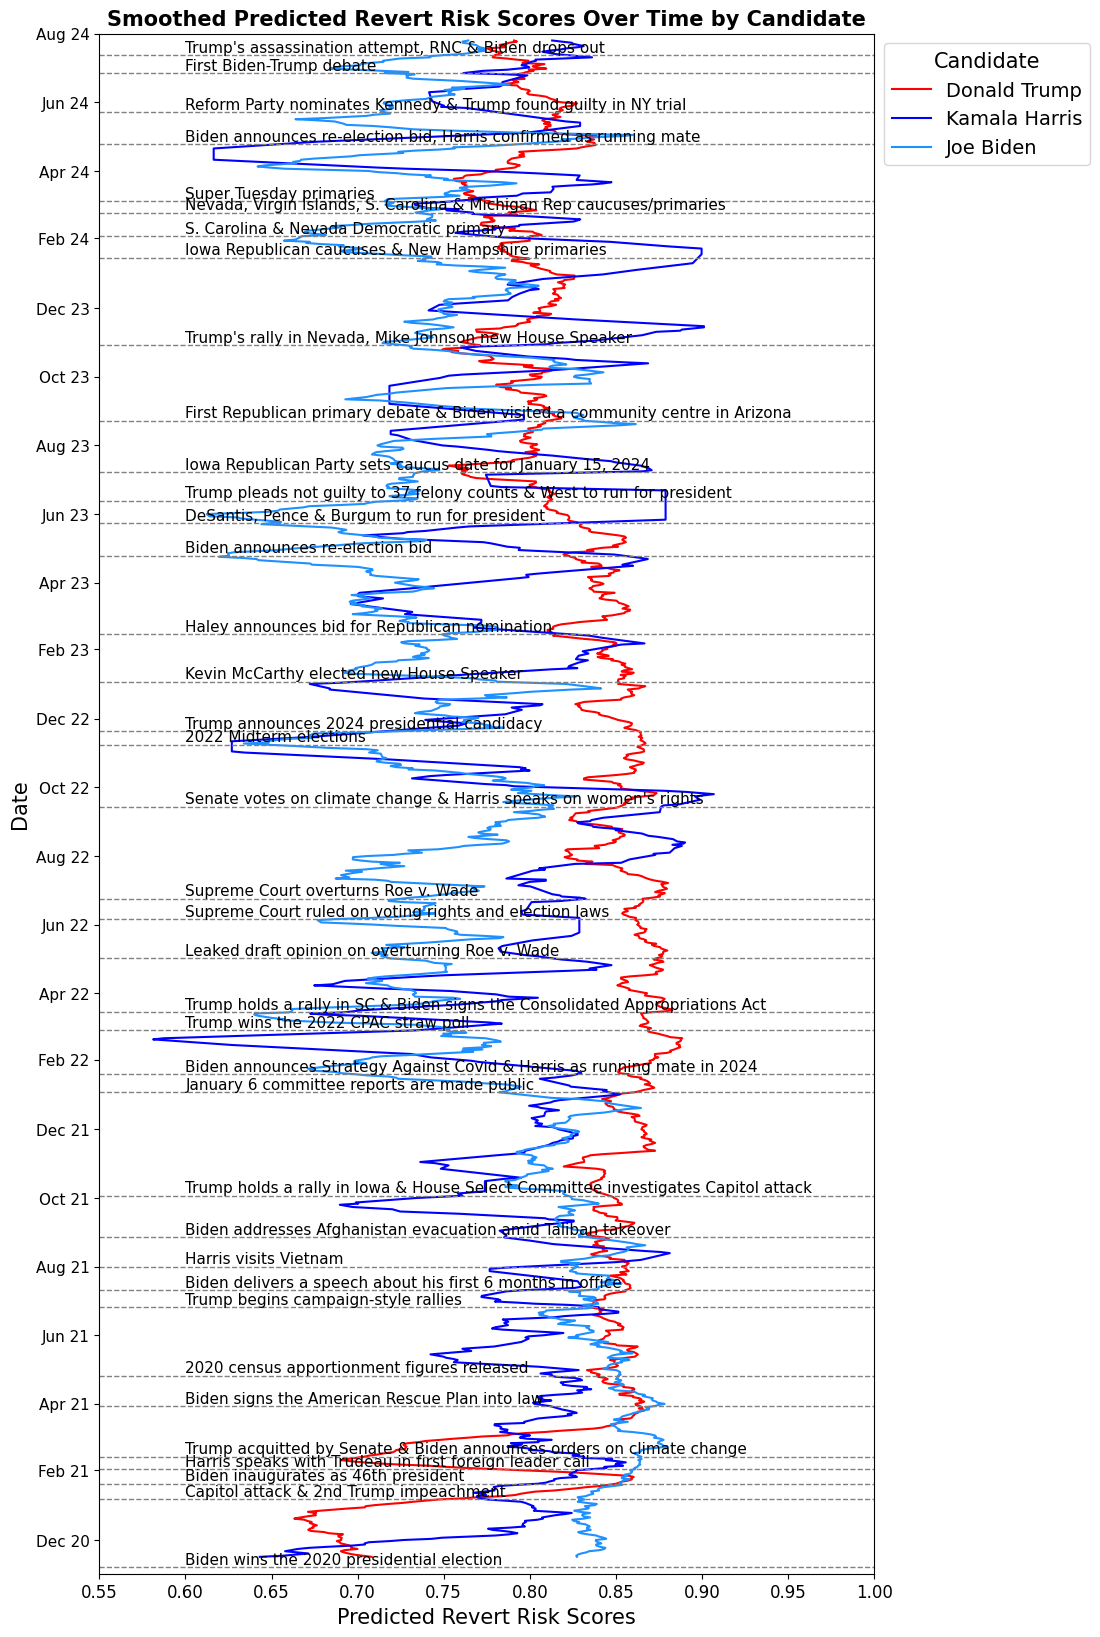

In [42]:
# Define columns
true_columns = ['trump_true', 'harris_true', 'biden_true']

# Define the corresponding colors for each column
colors = {
    'harris_true': 'blue',
    'biden_true': 'dodgerblue',
    'trump_true': 'red',
}

# Define the labels for each column
labels = {
    'harris_true': 'Kamala Harris',
    'biden_true': 'Joe Biden',
    'trump_true': 'Donald Trump',
}

# Plot the smoothed positive sentiment
plt.figure(figsize=(10, 20))

for true_column in true_columns:
    # Smooth the positive sentiment
    smoothed_positive = df_candidates[true_column].rolling(window=14).mean()

    # Plot the smoothed positive sentiment
    plt.plot(smoothed_positive, df_candidates.index, label=labels[true_column], color=colors[true_column])

# Add vertical lines and annotations for key dates
for date, event in events.items():
    plt.axhline(pd.to_datetime(date), color='gray', linestyle='--', linewidth=1)
    plt.text(0.60, pd.to_datetime(date), event, rotation=0, verticalalignment='bottom', fontsize=11)  

# Configure y-axis for monthly ticks
plt.gca().yaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

# Set limits
plt.xlim(0.55, 1)
plt.ylim(pd.to_datetime('2020-11'), pd.to_datetime('2024-08')) 

plt.ylabel('Date', fontsize=15) 
plt.xlabel('Predicted Revert Risk Scores', fontsize=15) 
plt.title('Smoothed Predicted Revert Risk Scores Over Time by Candidate', fontsize=15, fontweight='bold')
plt.legend(bbox_to_anchor=(1,1), loc='best', title='Candidate', fontsize=14, title_fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=11) 

# Save the plot in high resolution
plt.savefig("figures/time-series-risk-candidates.png", dpi=400, bbox_inches='tight')

# Show plot
plt.show()
